Importing all the dependencies and loading 

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=0)

Text(0.5, 1.0, 'tensor(7)')

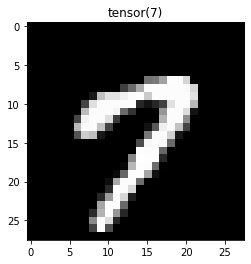

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
images, labels = next(iter(train_loader))
plt.figure(figsize = (5, 4))
images = images.numpy()
i = np.random.randint(1, 16)
img = np.squeeze(images[i])
plt.imshow(img, cmap = 'gray')
plt.title(labels[i])

In [4]:
if torch.cuda.is_available():
    train_on_gpu = True
    print("Using GPU")
else:
    train_on_gpu = False
    print("Using CPU")

Using GPU


Defining the Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 64)
        self.fc5 = nn.Linear(64, 256)
        self.fc6 = nn.Linear(256, 784)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
model = Autoencoder()
if train_on_gpu:
    model.cuda()
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=784, bias=True)
)


Defining Loss parameter and optimizer

In [6]:
optim = torch.optim.SGD(model.parameters(), lr = 0.03)
criterion = nn.MSELoss()

In [7]:
epochs = 200
for e in range(1, epochs+1):
    train_loss = 0.0
    for images, _ in train_loader:
        
        images = images.cuda()
        images = images.view(images.size(0), -1)
        optim.zero_grad()
        fake_images = model(images)
        loss = criterion(images, fake_images)
        loss.backward()
        optim.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    if e%10 == 0 or e == 1:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        e, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.431073
Epoch: 10 	Training Loss: 0.972202
Epoch: 20 	Training Loss: 0.750614
Epoch: 30 	Training Loss: 0.646149
Epoch: 40 	Training Loss: 0.571826
Epoch: 50 	Training Loss: 0.530577
Epoch: 60 	Training Loss: 0.497352
Epoch: 70 	Training Loss: 0.465220
Epoch: 80 	Training Loss: 0.447177
Epoch: 90 	Training Loss: 0.431008
Epoch: 100 	Training Loss: 0.412772
Epoch: 110 	Training Loss: 0.396974
Epoch: 120 	Training Loss: 0.382433
Epoch: 130 	Training Loss: 0.368949
Epoch: 140 	Training Loss: 0.357363
Epoch: 150 	Training Loss: 0.347199
Epoch: 160 	Training Loss: 0.338041
Epoch: 170 	Training Loss: 0.329488
Epoch: 180 	Training Loss: 0.322570
Epoch: 190 	Training Loss: 0.316777
Epoch: 200 	Training Loss: 0.311263


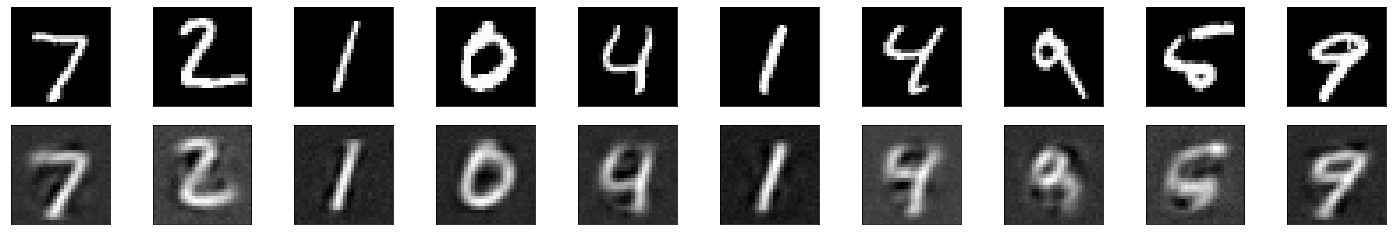

In [8]:
images, labels = next(iter(test_loader))

images_flatten = images.view(images.size(0), -1)
images_flatten = images_flatten.cuda()
output = model(images_flatten)
images = images.cpu()
images = images.numpy()

output = output.view(16, 1, 28, 28)
output = output.cpu()

output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)